<a href="https://colab.research.google.com/github/Pryscilla123/Algortimo-DP-Covid19/blob/main/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2 as cv
torch.__version__

'1.8.1+cu101'

In [ ]:
!pip install split-folders

In [ ]:
!pip install split-folders tqdm

In [ ]:
import splitfolders

In [ ]:
torch.manual_seed(123)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir = '/content/gdrive/My Drive/COVID-19-master/X-Ray Image DataSet'

In [ ]:
#dividindo o dataset entre treinamento, teste e validação
splitfolders.ratio(data_dir, output='dataset', seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 1192 files [08:16,  2.40 files/s]


In [ ]:
data_dir_test = '/content/dataset/test'
data_dir_train = '/content/dataset/train'

In [ ]:
#passando pelo transformador de imagem, normalizando e passando para tensor(o de treinamento aumenta o numero de imagens)
#tem poucas imagens, por isso eu aumento
transform_train = transforms.Compose(
    [
     transforms.Resize([64, 64]), #padronizando o tamanho
     #aumentando algumas imagens ao dataset pegando algumas já existente e transformando em outras com umas mudanças
     transforms.RandomHorizontalFlip(), #imagens novas giradas horizontalmente
     transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)), #mudando alguns aspectos
     transforms.ToTensor() #passando para tensor
    ]
)

In [ ]:
transform_test = transforms.Compose(
    [
     transforms.Resize([64, 64]), #redimensionando
     transforms.ToTensor() #passando para tensor
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train) #criando o dataset de treinamento

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 953
    Root location: /content/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True) #passando o dataset para loader
#batch_size significa que será criado vários conjuntos com 32 imagens cadas e a cada 32 imagens vai ter a atualização de pesos e kernels

In [ ]:
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test) #mesma coisa com o dataset do teste

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 121
    Root location: /content/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear)
               ToTensor()
           )

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True) #mesma coisa com o loader do teste

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(64, 64, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=64)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # convolução 1: (64 - 3 + 1) / 1 = 62x62
    # pooling 1: 31x31
    # convolução 2: (31 - 3 + 1) / 1 = 29x29
    # pooling 2: 14x14
    # 14 * 14 * 64
    # 12.544 -> 128 -> 128 -> 3
    self.linear1 = nn.Linear(in_features=14*14*64, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 3)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X

In [ ]:
classificador = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classificador.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
classificador.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=12544, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
                
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = classificador(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs) #transformando o output em probabilidade 
        top_p, top_class = ps.topk(k = 1, dim = 1) #alguns parametros para que isso ocorra
        equals = top_class == labels.view(*top_class.shape) #colocando a igualdade pegando a maior probabilidade
        #tipo pode acontecer de ter 60% de chance de ser covid, então o output será 0

        accuracy = torch.mean(equals.type(torch.float)) #critério de avaliação accuracy

        running_accuracy += accuracy

              
        # Imprimindo os dados referentes a este loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, 
                                   accuracy), end = '\r')
        
    # Imprimindo os dados referentes a esta época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch+1, running_loss/len(loader), 
                     running_accuracy/len(loader)))

In [ ]:
for epoch in range(10):
  print('Treinando...')
  training_loop(train_loader, epoch)
  classificador.eval()
  print('Validando...')
  training_loop(test_loader, epoch)
  classificador.train()

Treinando...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ÉPOCA   1 FINALIZADA: perda 0.92650 - precisão 0.59887
Validando...
ÉPOCA   1 FINALIZADA: perda 1.03386 - precisão 0.50813
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.77748 - precisão 0.65558
Validando...
ÉPOCA   2 FINALIZADA: perda 0.83557 - precisão 0.59094
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.69189 - precisão 0.68742
Validando...
ÉPOCA   3 FINALIZADA: perda 0.85824 - precisão 0.58281
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.64770 - precisão 0.70925
Validando...
ÉPOCA   4 FINALIZADA: perda 0.89931 - precisão 0.55281
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.62746 - precisão 0.70792
Validando...
ÉPOCA   5 FINALIZADA: perda 0.82860 - precisão 0.54500
Treinando...
ÉPOCA   6 FINALIZADA: perda 0.58967 - precisão 0.74183
Validando...
ÉPOCA   6 FINALIZADA: perda 0.67717 - precisão 0.65438
Treinando...
ÉPOCA   7 FINALIZADA: perda 0.57493 - precisão 0.73708
Validando...
ÉPOCA   7 FINALIZADA: perda 0.66556 - precisão 0.74563
Treinando...
ÉPOCA   8 FINALIZADA: perda 0.55684 - precisão 0

In [ ]:
data_dir_val = '/content/dataset/val'

In [ ]:
def classificar_imagem(fname):
  from PIL import Image
  import matplotlib.pyplot as plt
  imagem_teste = Image.open(data_dir_val + '/' + fname)
  plt.imshow(imagem_teste)

  #parte de arrumar a imagem e passar para tensor
  import numpy as np
  imagem_teste = imagem_teste.resize((64, 64)) #redimencionando
  imagem_teste = imagem_teste.convert('RGB') #colocando o canal de cor, nesse caso RGB
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3) #passando para numpy array
  imagem_teste = imagem_teste / 255 #padronizando a matriz em números entre 0 e 1
  imagem_teste = imagem_teste.transpose(2, 0, 1) #passando o transpose que muda a ordem das dimensões pegando primeiro
  #o batch_size e por ultimo os canais de cores
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)#passando para tensor

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  output = classificador.forward(imagem_teste)
  output = F.softmax(output)#passando o output para probabilidade
  output = output.cpu().detach().numpy()
  index = np.argmax(output)#arredondando o resultado

  print(index)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}#pega o nome da posição correspondente
  #ao output

  return idx_to_class[index]

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'Covid-19'

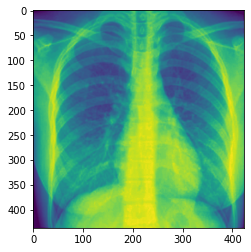

In [ ]:
imagem = '/Covid-19/kjr-21-e25-g001-l-a.jpg'
classificar_imagem(imagem)